## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

## Initializing Data

In [2]:
driver_dtypes = {'Local Case Number': "string", "Num Motorist Involved": "string"}
df = pd.read_csv("../Datasets/prepared_data.csv", dtype=driver_dtypes)

target2 = ["Vehicle Damage Extent Remapped"]
target2_feats = ["Collision Type", "Vehicle Make", "Vehicle Movement", "Incident Hit/Run", "NonTraffic", "Route Type",
                 "Vehicle Second Impact Location", "Vehicle First Impact Location", "Vehicle Body Type", "First Harmful Event",
                 "Driver At Fault", "Speed Limit", "Number of Lanes", "Parked Vehicle", "Lane Number", "Light",
                 "Traffic Analysis Zone", "Policy Name", "Hour Range"]

target2_df = df[target2+target2_feats]

## Checking Distribution

In [3]:
target2_df = target2_df[target2_df[target2[0]] != "OTHER"]
target2_df[target2].value_counts(normalize=True)

Vehicle Damage Extent Remapped
DESTROYED OR DISABLING            0.424315
NO DAMAGE OR SUPERFICIAL          0.303185
FUNCTIONAL                        0.272501
dtype: float64

In [4]:
target2_df.shape

(171313, 20)

In [5]:
target2_df = target2_df.dropna()
target2_df[target2].value_counts(normalize=True)

Vehicle Damage Extent Remapped
DESTROYED OR DISABLING            0.437819
NO DAMAGE OR SUPERFICIAL          0.289768
FUNCTIONAL                        0.272413
dtype: float64

In [6]:
target2_df.reset_index(inplace=True, drop=True)
target2_df.shape

(153271, 20)

In [7]:
def test_normality(distro):
    stat, p = stats.shapiro(distro)
    alpha = 0.05

    if p > alpha:
        print("p =",p)
        print("Normal Distribution (Fail to Reject Null Hypothesis)")
    else:
        print("Not Normal Distribution (Reject Null Hypothesis)")

In [8]:
test_normality(target2_df[target2].value_counts(normalize=True).tolist())

p = 0.1825898140668869
Normal Distribution (Fail to Reject Null Hypothesis)


## Test For Multicolinearity

In [9]:
corr = pd.DataFrame(index=target2_feats+target2, columns=target2_feats+target2)

In [10]:
def get_cramers_v(idx, col, n):
    contingency_table = pd.crosstab(idx, col)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    feature_shape = contingency_table.shape[0]
    target_shape = contingency_table.shape[1]
    cramers_v = np.sqrt(chi2 / (n * min(feature_shape-1, target_shape-1)))
    return cramers_v

In [11]:
for idx in corr.index:
    for col in corr.columns:
        corr.at[idx, col] = get_cramers_v(target2_df[idx], target2_df[col], target2_df.shape[0])

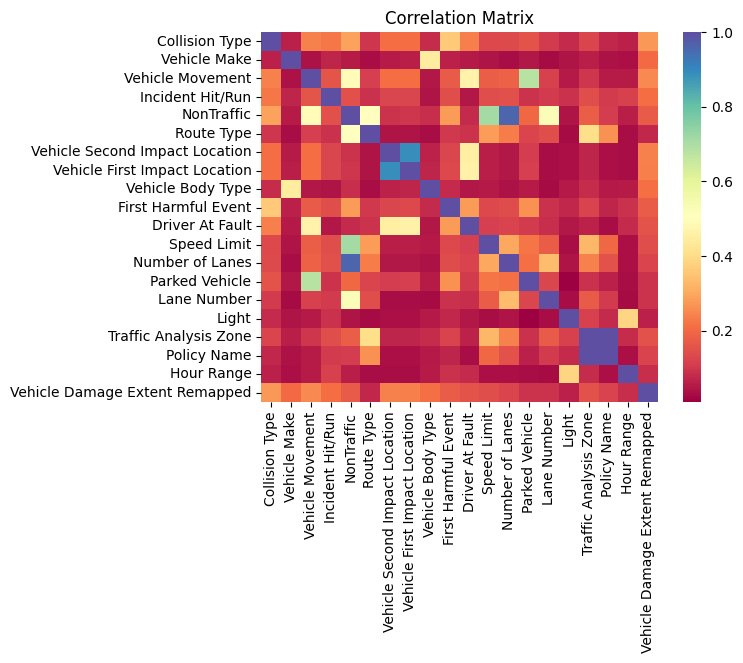

In [12]:
sns.heatmap(corr.astype(float), cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title("Correlation Matrix")
plt.show()

To start I am going to remove a few features do to multicolinearity. 

**Traffic Analysis Zone** has a perfect correlation with Policy name. This make sense due to they were both derived from the same supplementary data set. While Traffic analysis zone does have a better correlation with the target variable than policy name, it also has 10 time the amount of features. Thus to reduce spatial complexity in the model, for the time being it makes the most sense to use policy name instead of traffic analysis zone.

**Number of Lanes** and Nontraffic also almost have a perfect correlation. NonTraffic being binary, and having a higher correlation with the target variable than Number of Lanes, makes it the feature that should be kept. Thus, Number of Lanes will be dropped from the dataset.

**Vehicle Second Impact Location** also has a high correlation with Vehicle First Impact Location. Both variables have the same correlation with the target so the second is what will be dropped as it comes after the first.

## Variable Encoding

In [13]:
target2_df.drop(columns=["Traffic Analysis Zone", "Number of Lanes", "Vehicle Second Impact Location"], inplace=True)

In [14]:
binary_feats = ["Incident Hit/Run", "NonTraffic", "Driver At Fault", "Parked Vehicle"]
ordinal_feats = ["Vehicle First Impact Location", "Speed Limit", "Lane Number", "Hour Range"]
nominal_feats = ["Collision Type", "Vehicle Make", "Vehicle Movement", "Route Type", "Vehicle Body Type", "First Harmful Event",
                 "Light", "Policy Name"]

In [15]:
model_df = pd.get_dummies(target2_df, columns=nominal_feats)

In [16]:
for col in binary_feats + ordinal_feats:
    model_df[col] = model_df[col].astype('category').cat.codes

## Classifiers
#### Parameter Selections

In [17]:
def gridSearch(clf, params, df, n_rows, score='f1_weighted', is_y_np=False, _target="Vehicle Damage Extent Remapped"):
    df = df[: n_rows]
    
    X_n = df.drop(columns=[_target])
    y_n = df[_target]
    y_np = df[_target].values
    y_np = LabelEncoder().fit_transform(y_np)
    
    grid_search = GridSearchCV(clf, params, cv=10, scoring=score)
    
    if is_y_np:
        grid_search.fit(X_n, y_np)
    else:
        grid_search.fit(X_n, y_n)
    
    return grid_search

In [18]:
%%time
rf_params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

gs_rf = gridSearch(RandomForestClassifier(), rf_params, model_df, int(model_df.shape[0]*.10)) 
print("Best Random Forest parameters found: ", gs_rf.best_params_)
print("Best Random Forest f1_weighted found: ", gs_rf.best_score_)

Best Random Forest parameters found:  {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 500}
Best Random Forest f1_weighted found:  0.5961213701654454
CPU times: total: 46min 41s
Wall time: 49min 53s


In [19]:
%%time 
bernNB_params = {'fit_prior': [True, False],
                        'alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20, 25, 50, 100]}
gs_bernNB = gridSearch(BernoulliNB(), bernNB_params, model_df.loc[:, ~model_df.columns.isin(ordinal_feats)], model_df.shape[0])
print("Best BernoulliNB parameters found: ", gs_bernNB.best_params_)
print("Best BernoulliNB f1_weighted found: ", gs_bernNB.best_score_)

Best BernoulliNB parameters found:  {'alpha': 5, 'fit_prior': True}
Best BernoulliNB f1_weighted found:  0.5680809066700119
CPU times: total: 4min 42s
Wall time: 5min 6s


In [20]:
%%time
compNB_params = {'norm': [True, False],
                 'alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20, 25, 50, 100]}
gs_compNB = gridSearch(ComplementNB(), compNB_params, model_df, model_df.shape[0])
print("Best ComplementNB parameters found: ", gs_compNB.best_params_)
print("Best ComplementNB f1_weighted found: ", gs_compNB.best_score_)

Best ComplementNB parameters found:  {'alpha': 20, 'norm': False}
Best ComplementNB f1_weighted found:  0.5641987029464881
CPU times: total: 4min 15s
Wall time: 4min 40s


In [21]:
%%time
xgb_params = {'booster': ['gbtree'],
              'eta': [0.01, 0.05, 0.1],
              'max_depth': [3, 6, 9],
              'min_child_weight': [0.25, 0.5, 1, 5],
              'lambda': [0.1, 1.0, 10.0],
              'alpha': [0.0, 0.1, 0.5],
              'objective': ['multi:softmax'],
              'num_class': [4],
              'tree_method':['hist']}

gs_xgb = gridSearch(xgb.XGBClassifier(), xgb_params, model_df, int(model_df.shape[0]*.10), is_y_np=True)
print("Best XGBoost parameters found: ", gs_xgb.best_params_)
print("Best XGBoost f1_weighted found: ", gs_xgb.best_score_)

Best XGBoost parameters found:  {'alpha': 0.1, 'booster': 'gbtree', 'eta': 0.1, 'lambda': 1.0, 'max_depth': 6, 'min_child_weight': 0.5, 'num_class': 4, 'objective': 'multi:softmax', 'tree_method': 'hist'}
Best XGBoost f1_weighted found:  0.5939561936645722
CPU times: total: 9h 52min 19s
Wall time: 1h 11min 51s


#### Model Evaluations with Selected Parameters

In [22]:
classifiers = ["Random Forest", "BernoulliNB", "ComplementNB", "XGBoost"]
accs = []
f1s = []

In [23]:
def plot_cm(df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, cmap = 'viridis', annot=True, fmt="d", square=True, linewidths=.5)
    plt.xlabel("Predicted Values", fontsize=10)
    plt.ylabel("Actual Values", fontsize=10)
    plt.xticks(wrap=True, fontsize=7, rotation=0)
    plt.yticks(wrap=True, fontsize=7)
    plt.title(title)
    plt.show()

In [24]:
def kfold_eval(clf, X, y):
    acc = []
    f1_weighted = []
    cm = []
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    for train, test in kf.split(X, y):
        clf.fit(X.iloc[train], y[train])
        y_pred = clf.predict(X.iloc[test])
        class_names = sorted(set(y[test]) | set(y_pred))
        acc += [accuracy_score(y[test], y_pred)]
        f1_weighted += [f1_score(y[test], y_pred, average='weighted')]
        cm += [pd.DataFrame(confusion_matrix(y[test], y_pred, labels=class_names), index=class_names, columns=class_names)]
    return acc, f1_weighted, cm

In [25]:
X = model_df.drop(columns=["Vehicle Damage Extent Remapped"])
y = model_df["Vehicle Damage Extent Remapped"]

X_np = model_df.drop(columns=["Vehicle Damage Extent Remapped"]).values
y_np = model_df["Vehicle Damage Extent Remapped"].values
y_np = LabelEncoder().fit_transform(y_np)

In [26]:
%%time
rf = RandomForestClassifier(**gs_rf.best_params_)

acc, f1_weighted, cm = kfold_eval(rf, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Random Forest CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

Random Forest CV accuracy=0.605 0.014
Random Forest CV f1_weighted=0.595 0.008
CPU times: total: 12min 54s
Wall time: 13min 22s


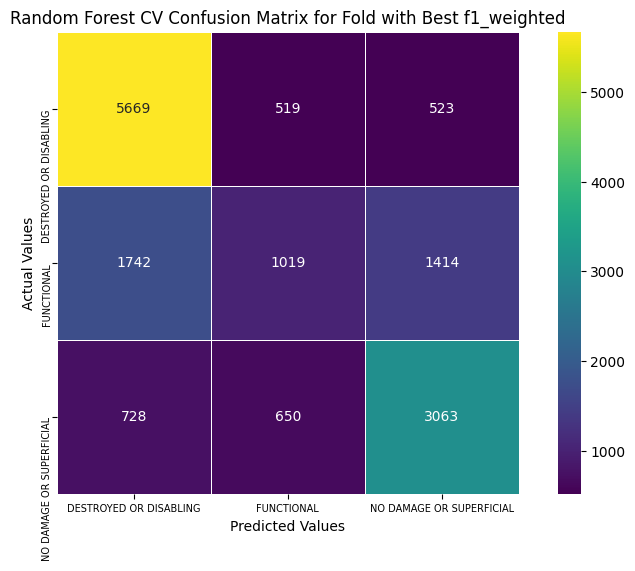

In [27]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'Random Forest CV Confusion Matrix for Fold with Best f1_weighted')

In [28]:
%%time
bernNB = BernoulliNB(**gs_bernNB.best_params_)

acc, f1_weighted, cm = kfold_eval(bernNB, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'BernoulliNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'BernoulliNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

BernoulliNB CV accuracy=0.576 0.015
BernoulliNB CV f1_weighted=0.569 0.010
CPU times: total: 11.3 s
Wall time: 12.2 s


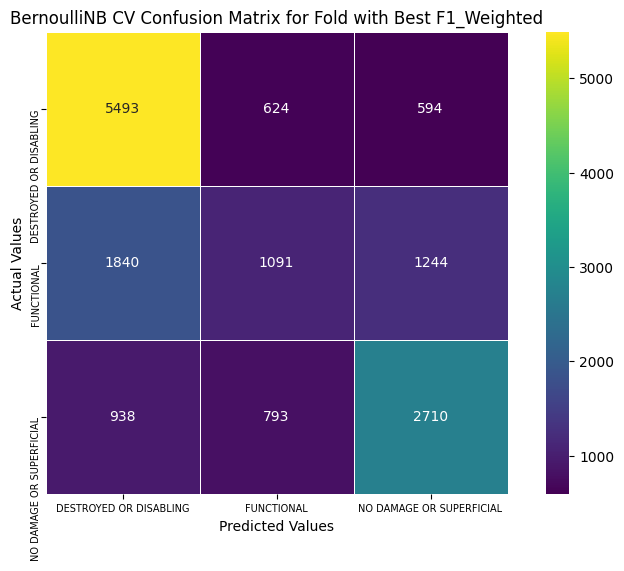

In [29]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'BernoulliNB CV Confusion Matrix for Fold with Best F1_Weighted')

In [30]:
%%time
compNB = ComplementNB(**gs_compNB.best_params_)

acc, f1_weighted, cm = kfold_eval(compNB, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'ComplementNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'ComplementNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

ComplementNB CV accuracy=0.577 0.014
ComplementNB CV f1_weighted=0.564 0.007
CPU times: total: 10.2 s
Wall time: 10.9 s


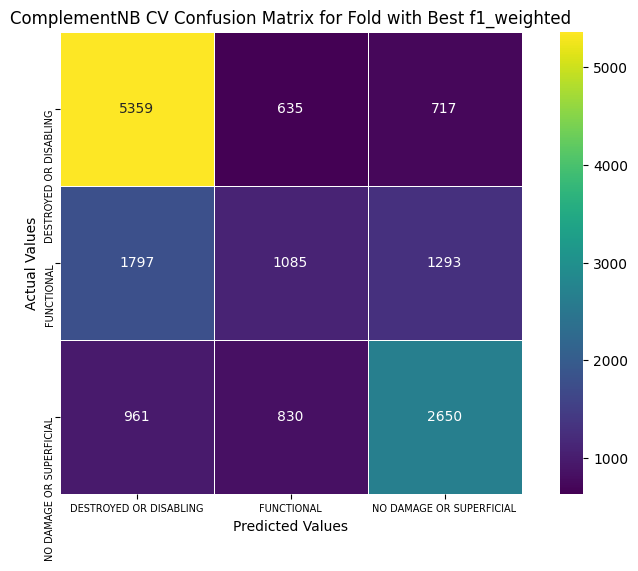

In [31]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'ComplementNB CV Confusion Matrix for Fold with Best f1_weighted')

In [32]:
%%time
xgb_clf = xgb.XGBClassifier(**gs_xgb.best_params_)

acc, f1_weighted, cm = kfold_eval(xgb_clf, X, y_np)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'XGBoost CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'XGBoost CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

XGBoost CV accuracy=0.611 0.013
XGBoost CV f1_weighted=0.586 0.008
CPU times: total: 7min 14s
Wall time: 47.4 s


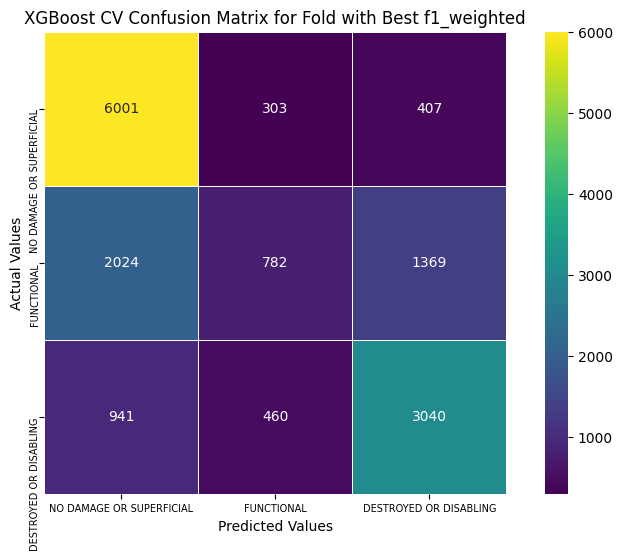

In [33]:
best_cm = cm[f1_weighted.index(max(f1_weighted))]
best_cm.index = target2_df["Vehicle Damage Extent Remapped"].unique().tolist()
best_cm.columns = target2_df["Vehicle Damage Extent Remapped"].unique().tolist()
plot_cm(best_cm, 'XGBoost CV Confusion Matrix for Fold with Best f1_weighted')

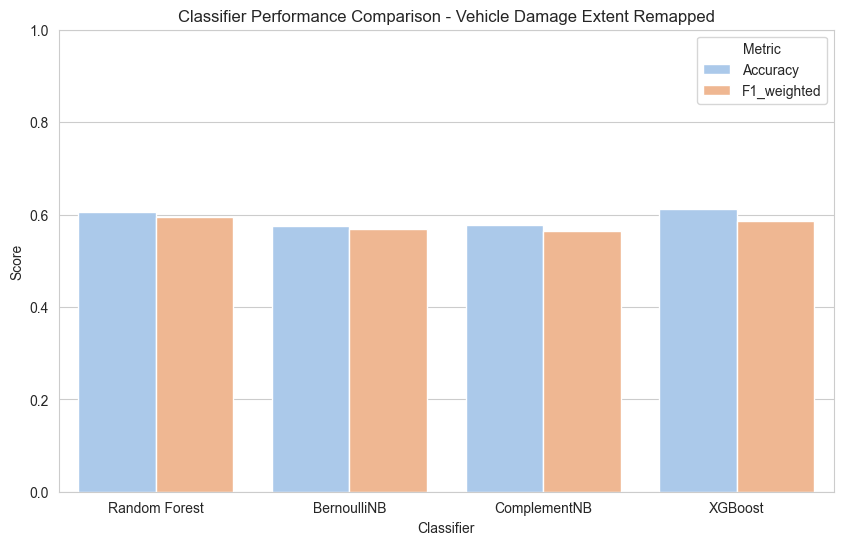

In [34]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

data = {
    'Classifier': classifiers,
    'Accuracy': accs,
    'F1_weighted': f1s
}

results = pd.DataFrame(data)
results = pd.melt(results, id_vars='Classifier', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Classifier', y='Value', hue='Metric')
plt.title('Classifier Performance Comparison - Vehicle Damage Extent Remapped')
plt.ylabel('Score')
plt.xlabel('Classifier')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()

### Creating Binary Target Variable

In [35]:
bin_map = {"NO DAMAGE OR SUPERFICIAL": "DRIVABLE", "FUNCTIONAL": "DRIVABLE",
             "DESTROYED OR DISABLING": "NOT DRIVABLE"}
model_df["Vehicle Damage Extent Binary"] = model_df["Vehicle Damage Extent Remapped"].replace(bin_map)

In [36]:
model_df["Vehicle Damage Extent Binary"].value_counts(normalize=True)

DRIVABLE        0.562181
NOT DRIVABLE    0.437819
Name: Vehicle Damage Extent Binary, dtype: float64

In [37]:
model_df_2 = model_df.drop(columns=["Vehicle Damage Extent Remapped"])

#### Parameter Selections

In [38]:
%%time
rf_params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

gs_rf_2 = gridSearch(RandomForestClassifier(), rf_params, model_df_2, int(model_df_2.shape[0]*.10),
                     _target="Vehicle Damage Extent Binary") 
print("Best Random Forest parameters found: ", gs_rf_2.best_params_)
print("Best Random Forest f1_weighted found: ", gs_rf_2.best_score_)

Best Random Forest parameters found:  {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Best Random Forest f1_weighted found:  0.7545305852372759
CPU times: total: 46min 7s
Wall time: 47min 31s


In [39]:
%%time 
bernNB_params = {'fit_prior': [True, False],
                        'alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20, 25, 50, 100]}
gs_bernNB_2 = gridSearch(BernoulliNB(), bernNB_params, model_df_2.loc[:, ~model_df_2.columns.isin(ordinal_feats)],
                         model_df_2.shape[0], _target="Vehicle Damage Extent Binary")
print("Best BernoulliNB parameters found: ", gs_bernNB_2.best_params_)
print("Best BernoulliNB f1_weighted found: ", gs_bernNB_2.best_score_)

Best BernoulliNB parameters found:  {'alpha': 0.75, 'fit_prior': True}
Best BernoulliNB f1_weighted found:  0.7365490804760209
CPU times: total: 3min 55s
Wall time: 4min 7s


In [40]:
%%time
compNB_params = {'norm': [True, False],
                 'alpha': [ 0.001, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20]}
gs_compNB_2 = gridSearch(ComplementNB(), compNB_params, model_df_2, model_df_2.shape[0], _target="Vehicle Damage Extent Binary")
print("Best ComplementNB parameters found: ", gs_compNB_2.best_params_)
print("Best ComplementNB f1_weighted found: ", gs_compNB_2.best_score_)

Best ComplementNB parameters found:  {'alpha': 0.5, 'norm': False}
Best ComplementNB f1_weighted found:  0.7321640250472671
CPU times: total: 3min 21s
Wall time: 3min 31s


In [41]:
%%time
xgb_params = {'booster': ['gbtree'],
              'eta': [0.01, 0.05, 0.1],
              'max_depth': [3, 6, 9],
              'min_child_weight': [0.25, 0.5, 1, 5],
              'lambda': [0.1, 1.0, 10.0],
              'alpha': [0.0, 0.1, 0.5],
              'objective': ['multi:softmax'],
              'num_class': [4],
              'tree_method':['hist']}

gs_xgb_2 = gridSearch(xgb.XGBClassifier(), xgb_params, model_df_2, int(model_df_2.shape[0]*.10), is_y_np=True,
                     _target="Vehicle Damage Extent Binary")
print("Best XGBoost parameters found: ", gs_xgb_2.best_params_)
print("Best XGBoost f1_weighted found: ", gs_xgb_2.best_score_)

Best XGBoost parameters found:  {'alpha': 0.5, 'booster': 'gbtree', 'eta': 0.05, 'lambda': 10.0, 'max_depth': 9, 'min_child_weight': 1, 'num_class': 4, 'objective': 'multi:softmax', 'tree_method': 'hist'}
Best XGBoost f1_weighted found:  0.7553454423906056
CPU times: total: 6h 33min 50s
Wall time: 1h 5min 49s


In [42]:
%%time
logReg_params = {'clf__n_jobs': [-1],
                 'clf__penalty': ['l1', 'l2'],
                 'clf__solver': ['saga'],
                 'clf__C': [0.1, 0.25, 0.5, 1],
                 'clf__class_weight': ['balanced'],
                 'clf__tol': [0.00001, 0.0001, 0.001, 0.01],
                 'clf__max_iter': [50, 100, 250]}

pipeline = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())]) #mostly to standardize ordinal variables
gs_logReg = gridSearch(pipeline, logReg_params, model_df_2, int(model_df_2.shape[0]*.10),
                       _target="Vehicle Damage Extent Binary")
print("Best LogisticRegression parameters found: ", gs_logReg.best_params_)
print("Best LogisticRegression f1_weighted found: ", gs_logReg.best_score_)

Best LogisticRegression parameters found:  {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__max_iter': 100, 'clf__n_jobs': -1, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'clf__tol': 0.01}
Best LogisticRegression f1_weighted found:  0.7406994231121913
CPU times: total: 1min 15s
Wall time: 44min 3s


#### Model Evaluations with Selected Parameters

In [43]:
classifiers2 = ["Random Forest", "BernoulliNB", "ComplementNB", "XGBoost", "Logistic Regression"]
accs2 = []
f1s2 = []

In [44]:
X = model_df_2.drop(columns=["Vehicle Damage Extent Binary"])
y = model_df_2["Vehicle Damage Extent Binary"]

X_np = model_df_2.drop(columns=["Vehicle Damage Extent Binary"]).values
y_np = model_df_2["Vehicle Damage Extent Binary"].values
y_np = LabelEncoder().fit_transform(y_np)

In [45]:
%%time
rf = RandomForestClassifier(**gs_rf_2.best_params_)

acc, f1_weighted, cm = kfold_eval(rf, X, y)
accs2.append(np.mean(acc)); f1s2.append(np.mean(f1_weighted))
print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Random Forest CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

Random Forest CV accuracy=0.754 0.012
Random Forest CV f1_weighted=0.755 0.011
CPU times: total: 16min 11s
Wall time: 16min 46s


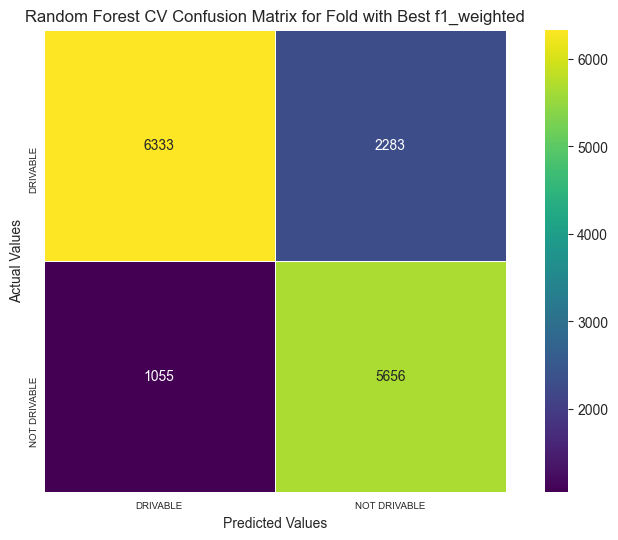

In [46]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'Random Forest CV Confusion Matrix for Fold with Best f1_weighted')

In [47]:
%%time
bernNB = BernoulliNB(**gs_bernNB_2.best_params_)

acc, f1_weighted, cm = kfold_eval(bernNB, X, y)
accs2.append(np.mean(acc)); f1s2.append(np.mean(f1_weighted))
print(f'BernoulliNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'BernoulliNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

BernoulliNB CV accuracy=0.736 0.009
BernoulliNB CV f1_weighted=0.736 0.009
CPU times: total: 9 s
Wall time: 9.64 s


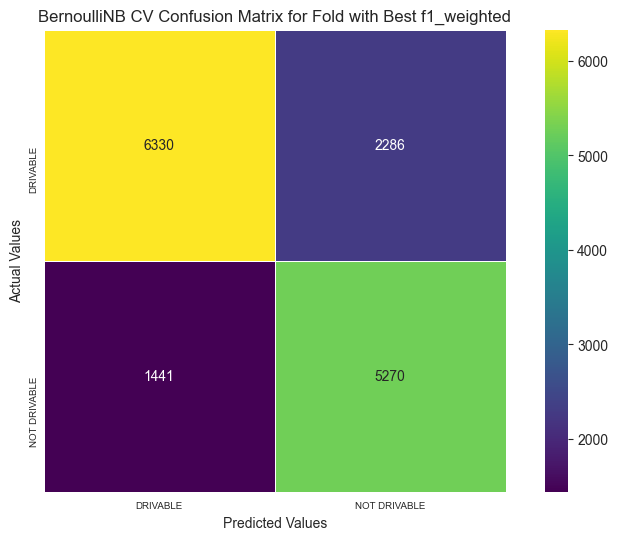

In [48]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'BernoulliNB CV Confusion Matrix for Fold with Best f1_weighted')

In [49]:
%%time
compNB = ComplementNB(**gs_compNB_2.best_params_)

acc, f1_weighted, cm = kfold_eval(compNB, X, y)
accs2.append(np.mean(acc)); f1s2.append(np.mean(f1_weighted))
print(f'ComplementNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'ComplementNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

ComplementNB CV accuracy=0.731 0.009
ComplementNB CV f1_weighted=0.732 0.009
CPU times: total: 7.89 s
Wall time: 8.55 s


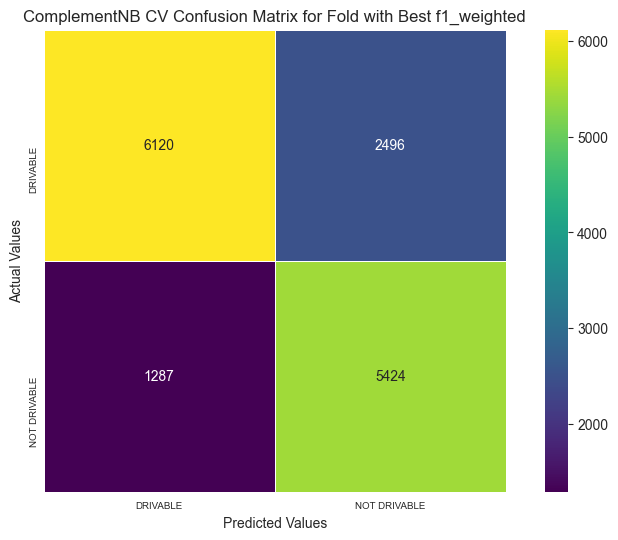

In [50]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'ComplementNB CV Confusion Matrix for Fold with Best f1_weighted')

In [51]:
%%time
xgb_clf = xgb.XGBClassifier(**gs_xgb_2.best_params_)

acc, f1_weighted, cm = kfold_eval(xgb_clf, X, y_np)
accs2.append(np.mean(acc)); f1s2.append(np.mean(f1_weighted))
print(f'XGBoost CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'XGBoost CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

XGBoost CV accuracy=0.757 0.012
XGBoost CV f1_weighted=0.758 0.012
CPU times: total: 8min 46s
Wall time: 1min 5s


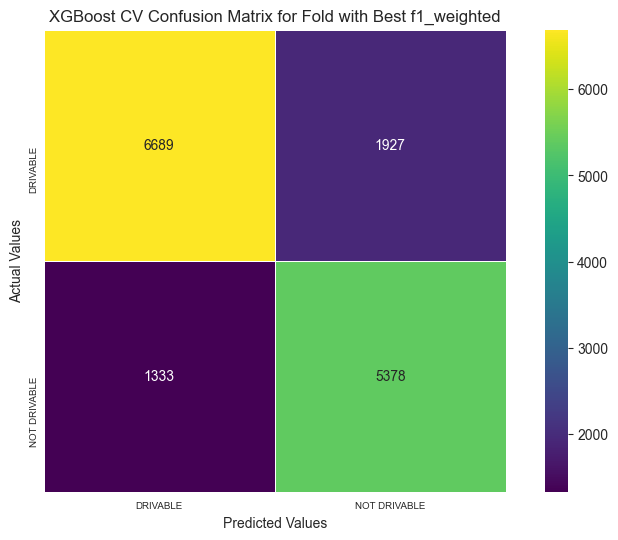

In [52]:
best_cm = cm[f1_weighted.index(max(f1_weighted))]
best_cm.index = model_df_2["Vehicle Damage Extent Binary"].unique().tolist()
best_cm.columns = model_df_2["Vehicle Damage Extent Binary"].unique().tolist()
plot_cm(best_cm, 'XGBoost CV Confusion Matrix for Fold with Best f1_weighted')

In [53]:
%%time
logReg_params = {param.replace('clf__', ''): value for param, value in gs_logReg.best_params_.items()}
logReg_clf = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(**logReg_params))])

acc, f1_weighted, cm = kfold_eval(logReg_clf, X, y)
accs2.append(np.mean(acc)); f1s2.append(np.mean(f1_weighted))
print(f'Logistic Regression CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Logistic Regression CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

Logistic Regression CV accuracy=0.744 0.012
Logistic Regression CV f1_weighted=0.744 0.012
CPU times: total: 25.9 s
Wall time: 28.7 s


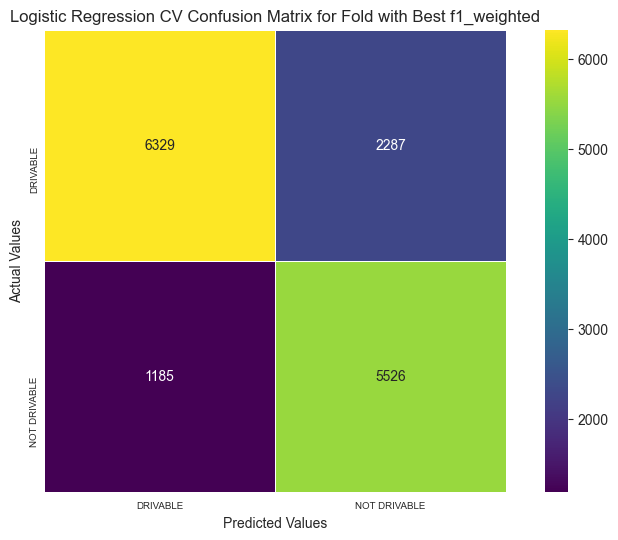

In [54]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'Logistic Regression CV Confusion Matrix for Fold with Best f1_weighted')

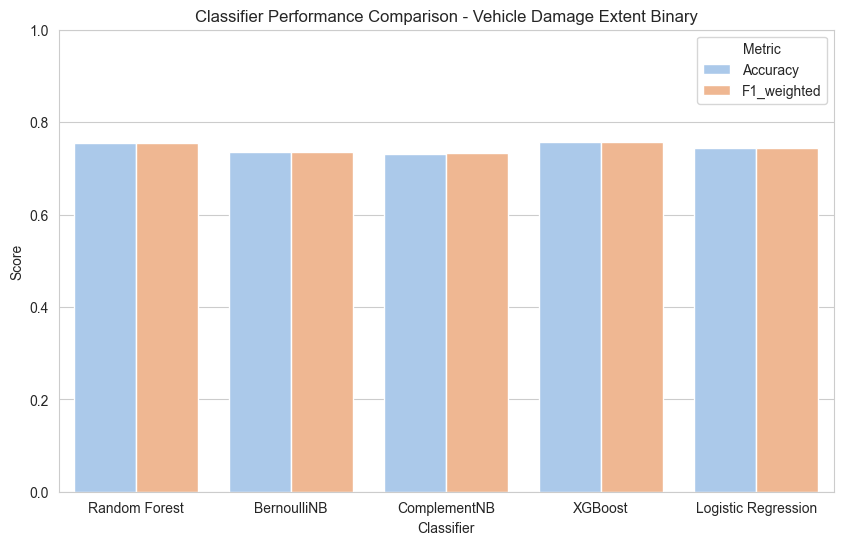

In [55]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

data = {
    'Classifier': classifiers2,
    'Accuracy': accs2,
    'F1_weighted': f1s2
}

results = pd.DataFrame(data)
results = pd.melt(results, id_vars='Classifier', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Classifier', y='Value', hue='Metric')
plt.title('Classifier Performance Comparison - Vehicle Damage Extent Binary')
plt.ylabel('Score')
plt.xlabel('Classifier')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()